# Training and predicting using a neural network

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import ast
import os
import sys
from os.path import dirname as up

# Important directories
code_dir = os.path.dirname(os.getcwd())
deep_cal_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Allows to import my own module
sys.path.insert(0, code_dir)

from ann.model import RegressorLiftedHeston
from ann.helpers import open_data, norm, create_train_test_split, plot_map
from ann.dataloader import LiftedHestonDataset
from ann.train import train

from torch.utils.data import DataLoader
from torch import nn, optim
import torch
import seaborn as sns

In [2]:
database = open_data(deep_cal_dir + '/data/heston_img.csv',info=True) 
database['vol_imp'] = database['vol_imp'].apply(ast.literal_eval)  
database['vol_imp'] = database['vol_imp'].apply(np.array)  


Five first rows of the generated DataFrame : 
           r       rho    lambda        nu     theta        v0  \
0  0.087345 -0.345281  1.797595  0.108334  0.373375  0.306434   
1  0.053734 -0.299285  0.815884  0.197408  0.314842  0.099705   
2  0.064063 -0.605398  1.594868  0.179371  0.353517  0.066062   
3  0.072809 -0.190020  1.548088  0.485789  0.139705  0.497143   
4  0.041415 -0.025787  1.500803  0.257766  0.135586  0.295568   

                                             vol_imp  
0  [2.5740481126152277, 1.2547427160366569, 0.684...  
1  [2.5740388185920797, 1.2469129301995416, 0.603...  
2  [2.574038812011191, 1.2468701153260764, 0.6083...  
3  [2.5742988249225363, 1.259290445567614, 0.6760...  
4  [2.574052452786126, 1.2501608960087736, 0.6332...  

DataFrame shape : (40000, 7)



In [3]:
train_data, train_labels, test_data, test_labels = create_train_test_split(database,0.8,1.,'vol_imp',norm=False,lifted=True,random_state = 123) 

In [4]:
train_dataset = LiftedHestonDataset(train_data,train_labels)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=1)

test_dataset = LiftedHestonDataset(test_data,test_labels)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=1)

In [5]:
model = RegressorLiftedHeston()

We can make a trial training with 100 epochs.

You can follow up training by going to your terminal and writing :
`
    >>> tensorboard --logdir=code/ann/runs/lifted_heston_experiment --port 6009
`

In [6]:
train(model,train_loader,test_loader,nb_epochs=100,seed=0,save_model_dir=code_dir + '/ann/ckpt_model',log_df= code_dir + '/ann/learning_csv/log_df.csv')

Validation loss decreased (inf --> 0.0014772784197703004).  Saving model ...
Validation loss decreased (0.0014772784197703004 --> 0.0008550407364964485).  Saving model ...
Validation loss decreased (0.0008550407364964485 --> 0.0007032030844129622).  Saving model ...
Validation loss decreased (0.0007032030844129622 --> 0.0005670597893185914).  Saving model ...
Validation loss decreased (0.0005670597893185914 --> 0.00043471658136695623).  Saving model ...
Validation loss decreased (0.00043471658136695623 --> 0.00039352159365080297).  Saving model ...
Validation loss decreased (0.00039352159365080297 --> 0.0003422597947064787).  Saving model ...
Validation loss decreased (0.0003422597947064787 --> 0.0003123811911791563).  Saving model ...
Validation loss decreased (0.0003123811911791563 --> 0.0003023374592885375).  Saving model ...
Validation loss decreased (0.0003023374592885375 --> 0.0002665255160536617).  Saving model ...
Validation loss decreased (0.0002665255160536617 --> 0.000255874

(    Train Losses         Test Losses  Learning Rate
 0       0.008353      tensor(0.0015)          0.001
 1       0.000935      tensor(0.0009)          0.001
 2       0.000749      tensor(0.0007)          0.001
 3       0.000635      tensor(0.0006)          0.001
 4       0.000504      tensor(0.0004)          0.001
 ..           ...                 ...            ...
 95      0.000086  tensor(8.7037e-05)          0.001
 96      0.000086  tensor(8.7079e-05)          0.001
 97      0.000085  tensor(8.5749e-05)          0.001
 98      0.000084  tensor(7.7731e-05)          0.001
 99      0.000085  tensor(8.6851e-05)          0.001
 
 [100 rows x 3 columns],
 tensor(7.7731e-05))

In [2]:
reg = RegressorLiftedHeston()
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reg.load_state_dict(torch.load(code_dir + '/ann/ckpt_model/modelLiftedHeston.pt'),map_location=torch.device(_device))

<All keys matched successfully>

In [3]:
reg.eval()
inp = torch.tensor([0.05,-0.3,1.5,0.2,0.3,0.1])
predictions =  reg(inp)
predictions = predictions.detach().numpy()


In [4]:
predictions = np.array(predictions,dtype=np.float64)
predictions = np.reshape(predictions, (11,8))

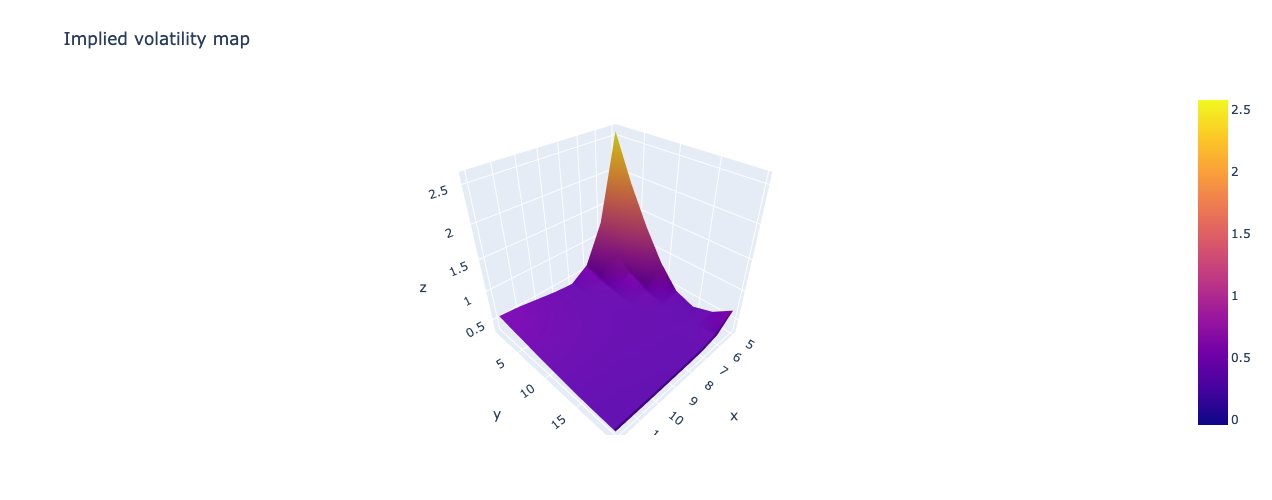

In [5]:
plot_map(predictions)